<a href="https://colab.research.google.com/github/Patience3/Transformer-For-Classification/blob/main/Tranformers4Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


####Load dataset

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.8MB/s]


Training samples: 60000
Test samples: 10000


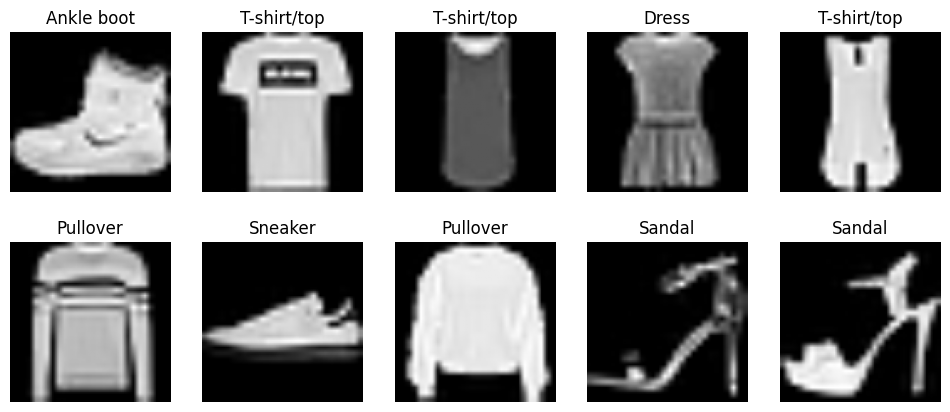

In [ ]:


# ------------------------
# 1. Define transformations
# ------------------------
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to ViT-friendly input
    transforms.ToTensor(),        # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale image
])

# ------------------------
# 2. Download datasets
# ------------------------
train_dataset = datasets.FashionMNIST(
    root="./data",       # directory to store dataset
    train=True,          # download training set
    transform=transform,
    download=True        # download if not present
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,         # download test set
    transform=transform,
    download=True
)

# ------------------------
# 3. Wrap datasets in DataLoader
# ------------------------
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# ------------------------
# 4. Verify the dataset
# ------------------------
# Print sizes
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

# Display a few example images
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flatten()):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(classes[label])
    ax.axis('off')
plt.show()


In [ ]:
# Data preprocessing & augmentation
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize for ViT patches
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

# Load datasets
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


###Patch embedding

In [ ]:
import torch.nn as nn

class PatchEmbedding(nn.Module):
    """
    Splits the image into patches and projects each patch to a hidden dimension.
    """
    def __init__(self, img_size=96, patch_size=16, hidden_dim=128):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        # 1-channel input (grayscale) → hidden_dim
        self.proj = nn.Conv2d(1, hidden_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Input x: [B, 1, 96, 96]
        x = self.proj(x)  # → [B, hidden_dim, num_patches_side, num_patches_side]
        x = x.flatten(2).transpose(1, 2)  # → [B, num_patches, hidden_dim]
        return x


In [ ]:
#Visualise pathch embedding
sample_img, _ = train_dataset[0]
sample_img = sample_img.unsqueeze(0)  # add batch dimension
patch_embed = PatchEmbedding()
patches = patch_embed(sample_img)
print("Original image shape:", sample_img.shape)
print("Patch embeddings shape:", patches.shape)


Original image shape: torch.Size([1, 1, 96, 96])
Patch embeddings shape: torch.Size([1, 36, 128])


###ViT transformer

In [ ]:
class ViTMLP(nn.Module):
    def __init__(self, hidden_dim, mlp_dim, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(hidden_dim, mlp_dim)
        self.act = nn.GELU()
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(mlp_dim, hidden_dim)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.drop1(self.act(self.fc1(x)))
        x = self.drop2(self.fc2(x))
        return x

class ViTBlock(nn.Module):
    """
    A single ViT block: self-attention + MLP + residual connections
    """
    def __init__(self, hidden_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, hidden_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Self-attention + residual
        attn_out, attn_weights = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_out
        # MLP + residual
        x = x + self.mlp(self.norm2(x))
        return x, attn_weights


###Visuals


In [ ]:
dummy_input = torch.randn(2, 37, 128)  # batch_size=2, 36 patches + CLS token
block = ViTBlock(hidden_dim=128, num_heads=4, mlp_dim=256)
out, attn = block(dummy_input)
print("Output shape:", out.shape)
print("Attention weights shape:", attn.shape)


Output shape: torch.Size([2, 37, 128])
Attention weights shape: torch.Size([2, 37, 37])


###Vison transformer model

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=96, patch_size=16, hidden_dim=128, mlp_dim=256,
                 num_heads=4, num_layers=2, num_classes=10, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, hidden_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, hidden_dim))
        self.dropout = nn.Dropout(dropout)

        # Stack of transformer blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_dim, num_heads, mlp_dim, dropout)
                                     for _ in range(num_layers)])
        self.norm = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        attn_weights_all = []
        for blk in self.blocks:
            x, attn_weights = blk(x)
            attn_weights_all.append(attn_weights)

        cls_out = self.head(self.norm(x[:, 0]))
        return cls_out, attn_weights_all


###Training Utilities

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def test_epoch(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs, _ = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


####Training Loop

Epoch 1/40
  Training   -> Loss: 0.4047, Accuracy: 0.8512
  Validation -> Loss: 0.4019, Accuracy: 0.8523
--------------------------------------------------
✅ Validation loss improved. Model saved.
Epoch 2/40
  Training   -> Loss: 0.3748, Accuracy: 0.8606
  Validation -> Loss: 0.4011, Accuracy: 0.8498
--------------------------------------------------
✅ Validation loss improved. Model saved.
Epoch 3/40
  Training   -> Loss: 0.3561, Accuracy: 0.8683
  Validation -> Loss: 0.3929, Accuracy: 0.8546
--------------------------------------------------
✅ Validation loss improved. Model saved.
Epoch 4/40
  Training   -> Loss: 0.3382, Accuracy: 0.8750
  Validation -> Loss: 0.3707, Accuracy: 0.8650
--------------------------------------------------
✅ Validation loss improved. Model saved.
Epoch 5/40
  Training   -> Loss: 0.3244, Accuracy: 0.8797
  Validation -> Loss: 0.3668, Accuracy: 0.8667
--------------------------------------------------
✅ Validation loss improved. Model saved.
Epoch 6/40
  Tr

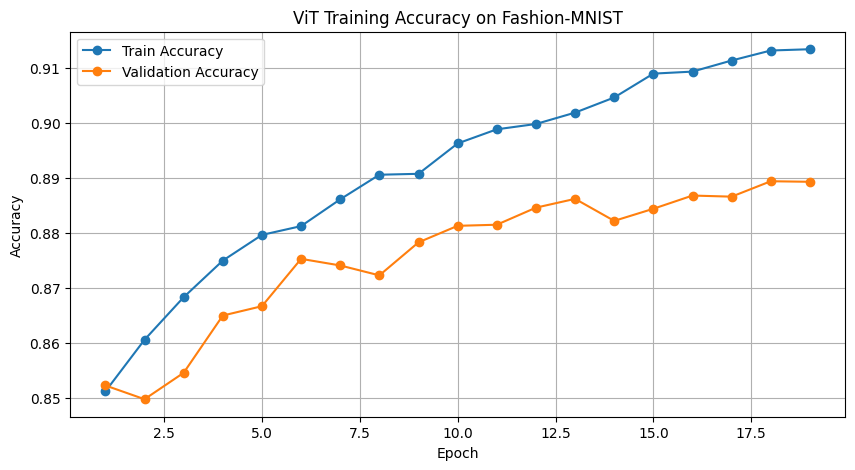

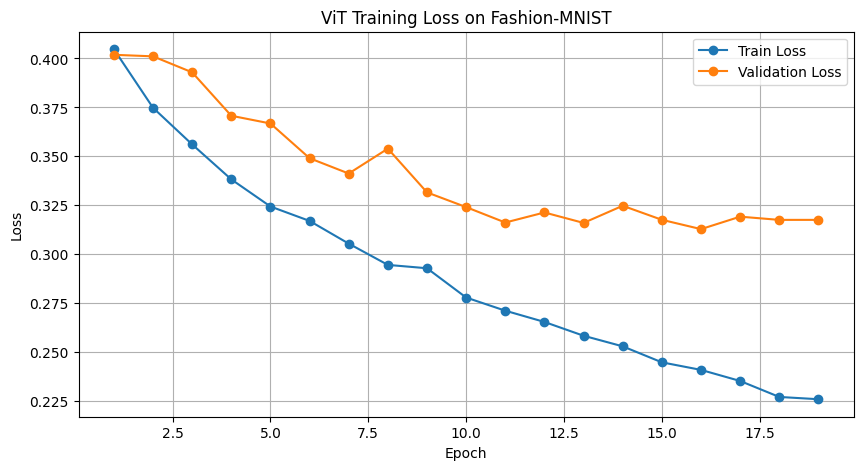

In [ ]:
import matplotlib.pyplot as plt
import torch

epochs = 40
patience = 3  # stop if no improvement for 3 epochs
best_val_loss = float('inf')
wait = 0  # counter for patience

train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []

for epoch in range(1, epochs + 1):
    # ---- Training ----
    train_loss, train_acc = train_epoch(model, train_loader)

    # ---- Validation ----
    test_loss, test_acc = test_epoch(model, test_loader)

    # ---- Store metrics ----
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    # ---- Verbose output ----
    print(f"Epoch {epoch}/{epochs}")
    print(f"  Training   -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"  Validation -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
    print("-" * 50)

    # ---- Early Stopping Check ----
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        wait = 0
        torch.save(model.state_dict(), "best_vit_model.pth")  # save best model
        print(f"✅ Validation loss improved. Model saved.")
    else:
        wait += 1
        print(f"⚠️ No improvement for {wait} epoch(s).")
        if wait >= patience:
            print(f"⛔ Early stopping triggered at epoch {epoch}.")
            break

# ---- After Training ----
# Load best model before evaluation
model.load_state_dict(torch.load("best_vit_model.pth"))

# ---- Plot accuracy over epochs ----
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_acc_list)+1), train_acc_list, label="Train Accuracy", marker='o')
plt.plot(range(1, len(test_acc_list)+1), test_acc_list, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ViT Training Accuracy on Fashion-MNIST")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot loss over epochs ----
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label="Train Loss", marker='o')
plt.plot(range(1, len(test_loss_list)+1), test_loss_list, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ViT Training Loss on Fashion-MNIST")
plt.legend()
plt.grid(True)
plt.show()


###Patch Level attention Visualiser

In [ ]:
def visualize_attention(model, image, layer=0, head=0):
    model.eval()
    img = image.unsqueeze(0).to(device)
    _, attn_weights_all = model(img)
    attn = attn_weights_all[layer][0, head]  # select batch 0, head 0
    cls_attn = attn[0, 1:].reshape(6, 6).detach().cpu().numpy()  # 6x6 patches
    plt.imshow(cls_attn, cmap='viridis')
    plt.title("CLS token attention over patches")
    plt.colorbar()
    plt.show()


####Step 8: Anomaly / Outlier Detection

Idea: Images that the model reconstructs poorly or has low classification confidence can be anomalies.

Detected 1274 low-confidence images.


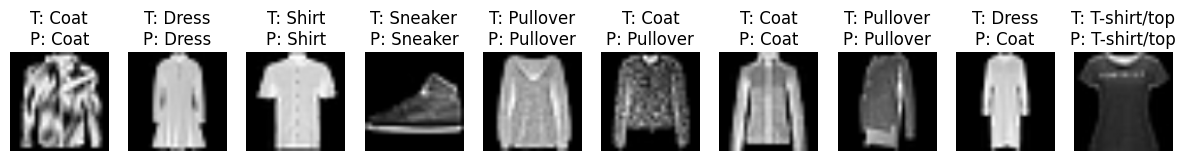

In [ ]:
# -----------------------------------
# 2. Anomaly detection with true labels
# -----------------------------------
def detect_outliers_with_labels(model, loader, threshold=0.7):
    """
    Detects low-confidence images (max softmax < threshold)
    and returns images, predicted labels, and true labels.
    """
    model.eval()
    outlier_imgs, outlier_preds, outlier_labels = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs, _ = model(imgs)
            probs = F.softmax(outputs, dim=1)
            max_conf, preds = probs.max(dim=1)

            mask = max_conf < threshold
            if mask.any():
                outlier_imgs.append(imgs[mask].cpu())
                outlier_preds.append(preds[mask].cpu())
                outlier_labels.append(labels[mask.cpu()].cpu()) # Move mask to CPU here

    # Flatten lists
    if len(outlier_imgs) > 0:
        outlier_imgs = torch.cat(outlier_imgs)
        outlier_preds = torch.cat(outlier_preds)
        outlier_labels = torch.cat(outlier_labels)
    else:
        outlier_imgs = torch.tensor([])
        outlier_preds = torch.tensor([])
        outlier_labels = torch.tensor([])

    return outlier_imgs, outlier_preds, outlier_labels

# Detect outliers
outlier_imgs, outlier_preds, outlier_labels = detect_outliers_with_labels(model, test_loader, threshold=0.7)
print(f"Detected {len(outlier_imgs)} low-confidence images.")

# Visualize first 10 outliers with true labels
num_to_show = min(10, len(outlier_imgs))
plt.figure(figsize=(15, 4))
for i in range(num_to_show):
    plt.subplot(1, num_to_show, i+1)
    plt.imshow(outlier_imgs[i].squeeze(), cmap='gray')
    plt.title(f"T: {classes[outlier_labels[i]]}\nP: {classes[outlier_preds[i]]}")
    plt.axis('off')
plt.show()

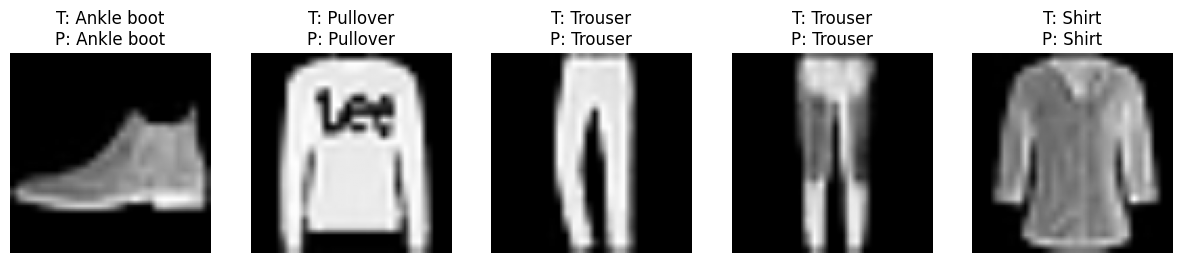

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Fashion-MNIST class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# -----------------------------------
# 1. Function to display predictions
# -----------------------------------
def test_predictions(model, test_loader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 4))

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs, _ = model(imgs)
            preds = outputs.argmax(dim=1)

            for i in range(imgs.size(0)):
                if images_shown >= num_images:
                    break
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(imgs[i].cpu().squeeze(), cmap='gray')
                plt.title(f"T: {classes[labels[i]]}\nP: {classes[preds[i]]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

# Example usage
test_predictions(model, test_loader, num_images=5)
